In [43]:
import pyarrow.orc as orc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import optuna
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Define the file path
path = r'C:/BigData/ProjectStaging/dataExport/fraud_mart_final.orc'

# 2. Load the file using PyArrow
orc_file = orc.ORCFile(path)

# 3. Read the table and slice it immediately to 16M rows
# table.slice(offset, length) is memory efficient
table = orc_file.read().slice(0, 16000000)

# 4. Convert to Pandas with "self_destruct" to keep memory footprint low
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Prevents needing one single massive contiguous block of RAM
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(f"Successfully loaded {len(df):,} rows.")
print(df.head())
print(df.info()) # Check memory usage

Successfully loaded 16,000,000 rows.
    transaction_id  user_id  card           merchant_id  label_is_fraud  \
0  61-5-1514771820       61     5   1799189980464955940               0   
1  61-5-1514894100       61     5  -4169251800658106093               0   
2  61-5-1515899580       61     5  -4752064311331295725               0   
3  61-5-1516172520       61     5   6455213054093379528               0   
4  61-5-1516275060       61     5  -4169251800658106093               0   

  amount  hour_of_day use_chip  merchant_category error_code  \
0   6.39            7     Chip               5499        N/A   
1  29.11           17     Chip               5812        N/A   
2  14.90            8     Chip               4214        N/A   
3  18.77           12   Online               5815        N/A   
4  34.77           17     Chip               5812        N/A   

   credit_utilization  state_mismatch  current_age yearly_income_person  \
0            0.000215               0           63  

### TIME EXTRACTION & SORTING

In [3]:
print("Step 1: extracting timestamps and sorting...")

import gc

# 1. Extract Unix Timestamp from transaction_id (Format: User-Card-Timestamp)
# taking the last part of the string '61-5-1514771820' -> '1514771820'
df['unix_time'] = df['transaction_id'].str.split('-').str[-1].astype(int)

# 2. Convert to Datetime object
df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 3. Sort by Time (Oldest -> Newest) to respect Time Series nature
df.sort_values('datetime', inplace = True)

# 4. Reset index IN-PLACE
df.reset_index(drop=True, inplace=True)

gc.collect()

df.head(5)

Step 1: extracting timestamps and sorting...


,transaction_id,user_id,card,merchant_id,label_is_fraud,amount,hour_of_day,use_chip,merchant_category,error_code,credit_utilization,state_mismatch,current_age,yearly_income_person,fico_score,card_type,card_brand,unix_time,datetime
0,791-1-662780400,791,1,2027553650310142703,0,68.00,7,Swipe,5541,N/A,0.002006,0,58,72510.00,727,Credit,Amex,662780400,1991-01-02 01:40:00
1,791-1-662780820,791,1,2027553650310142703,0,-68.00,7,Swipe,5541,N/A,-0.002006,0,58,72510.00,727,Credit,Amex,662780820,1991-01-02 01:47:00
2,791-1-662781060,791,1,2027553650310142703,0,113.62,7,Swipe,5541,N/A,0.003352,0,58,72510.00,727,Credit,Amex,662781060,1991-01-02 01:51:00
3,791-1-662817600,791,1,-7269691894846892021,0,114.73,17,Swipe,5411,N/A,0.003384,0,58,72510.00,727,Credit,Amex,662817600,1991-01-02 12:00:00
4,791-1-662873580,791,1,-3693650930986299431,0,251.71,9,Swipe,4814,N/A,0.007425,0,58,72510.00,727,Credit,Amex,662873580,1991-01-03 03:33:00


### FEATURE ENGINEERING (Time-Aware)

In [4]:
print("Step 2: Memory-Surgical Feature Engineering...")

# 1. Convert Decimal 'amount' to float32 immediately
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').astype(np.float32)

# 2. Convert Objects (Strings) to Categories
for col in ['use_chip', 'card_type', 'error_code', 'merchant_category']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 3. Extract Time Components & Cyclical Encoding
df['hour_of_day'] = df['datetime'].dt.hour.astype(np.int8)
df['day_of_week'] = df['datetime'].dt.dayofweek.astype(np.int8)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df.drop(columns=['hour_of_day', 'day_of_week'], inplace=True)
gc.collect()

# 4. FIXED: Memory-Surgical 'trans_last_24h' (Velocity)
print("Calculating Velocity (trans_last_24h) using NumPy...")
df.sort_values(['user_id', 'unix_time'], inplace=True)

user_ids = df['user_id'].values
unix_times = df['unix_time'].values
velocity_counts = np.zeros(len(df), dtype=np.int16)

# Find where each user's data starts and ends
user_changes = np.where(user_ids[:-1] != user_ids[1:])[0] + 1
user_starts = np.insert(user_changes, 0, 0)
user_ends = np.append(user_changes, len(df))

# Loop over each user (Efficient because it doesn't copy the DF)
for start, end in zip(user_starts, user_ends):
    user_time_window = unix_times[start:end]
    # For every transaction, find how many happened in the previous 86400 seconds
    # searchsorted is extremely fast (logarithmic time)
    lookback_indices = np.searchsorted(user_time_window, user_time_window - 86400, side='left')
    velocity_counts[start:end] = (np.arange(len(user_time_window)) - lookback_indices + 1).astype(np.int16)

df['trans_last_24h'] = velocity_counts
del user_ids, unix_times, velocity_counts, user_starts, user_ends, user_changes
gc.collect()

# 5. Time Since Last Transaction (Speed)
df['time_since_last_trans'] = df['unix_time'].diff().fillna(0).astype(np.float32)
user_changed = df['user_id'] != df['user_id'].shift(1)
df.loc[user_changed, 'time_since_last_trans'] = 0
del user_changed
gc.collect()

# 6. Amount Behavioral Features
print("Calculating user behavioral stats...")
user_medians = df.groupby('user_id')['amount'].transform('median').astype(np.float32)
df['diff_from_median'] = (df['amount'] - user_medians).astype(np.float32)
df['amount_ratio'] = (df['amount'] / (user_medians + 1)).astype(np.float32)
del user_medians
gc.collect()

# 7. Final Projection to save memory
cols_to_keep = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'state_mismatch', 'time_since_last_trans', 'hour_sin', 
    'hour_cos', 'day_sin', 'day_cos', 'diff_from_median', 'amount_ratio',
    'trans_last_24h', 'use_chip', 'card_type', 'error_code', 'merchant_category', 
    'label_is_fraud', 'unix_time'
]
df = df[cols_to_keep]
gc.collect()

print("Step 2 Finished successfully with zero memory leaks.")

Step 2: Memory-Surgical Feature Engineering...
Calculating Velocity (trans_last_24h) using NumPy...
Calculating user behavioral stats...
Step 2 Finished successfully with zero memory leaks.


### Temporal Splitting and Target Encoding

In [5]:
print("Step 3: Preparing Data for Splitting...")

# 1. Recover 'datetime' if it was dropped during memory optimization
if 'datetime' not in df.columns and 'unix_time' in df.columns:
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 2. Global Temporal Sort (Ensures Test = Future transactions)
# We sort by unix_time as it's faster than sorting by datetime objects
df.sort_values('unix_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Define Temporal Split (80% Train, 10% Val, 10% Test)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Print timing info to verify the split is chronological
print(f"--- Temporal Split Verification ---")
print(f"Train Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Val   Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"Test  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

# 4. Target Encoding for Merchant Category (Crucial: Use ONLY Training labels)
print("\nTarget encoding merchant_category...")
mcc_map = train_df.groupby('merchant_category')['label_is_fraud'].mean()
global_mean = train_df['label_is_fraud'].mean()

# Map the fraud risk scores and convert to float32 for memory efficiency
for d in [train_df, val_df, test_df]:
    d['mcc_risk'] = d['merchant_category'].map(mcc_map).fillna(global_mean).astype(np.float32)

# 5. Feature Selection
numeric_features = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'trans_last_24h', 'amount_ratio', 'state_mismatch',
    'time_since_last_trans', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'mcc_risk', 'diff_from_median'
]
categorical_features = ['use_chip', 'card_type', 'error_code']

X_train = train_df[numeric_features + categorical_features]
y_train = train_df['label_is_fraud']

X_val = val_df[numeric_features + categorical_features]
y_val = val_df['label_is_fraud']

X_test = test_df[numeric_features + categorical_features]
y_test = test_df['label_is_fraud']

# 6. Final Memory Clean up: Delete the original massive dataframe
del df
gc.collect()

print("\nStep 3 Complete. Train, Val, and Test sets are ready.")

Step 3: Preparing Data for Splitting...
--- Temporal Split Verification ---
Train Period: 1991-01-02 01:40:00 to 2017-04-17 04:45:00
Val   Period: 2017-04-17 04:46:00 to 2018-09-26 14:24:00
Test  Period: 2018-09-26 14:24:00 to 2020-02-28 18:28:00

Target encoding merchant_category...

Step 3 Complete. Train, Val, and Test sets are ready.


In [6]:
# Robustly convert all features to numeric for LGBM
for d in [X_train, X_val, X_test]:
    # 1. Fix 'yearly_income_person' (Object -> Float)
    if 'yearly_income_person' in d.columns:
        d['yearly_income_person'] = pd.to_numeric(d['yearly_income_person'], errors='coerce').astype(np.float32)
    
    # 2. Fix Categorical Features (Object/Category -> Integer Codes)
    for col in categorical_features:
        if col in d.columns:
            # Explicitly cast to category first to avoid AttributeError, then get codes
            d[col] = d[col].astype('category').cat.codes.astype(np.int32)

print("Check dtypes - All should now be int or float:")
print(X_train[categorical_features + ['yearly_income_person']].dtypes)

Check dtypes - All should now be int or float:
use_chip                  int32
card_type                 int32
error_code                int32
yearly_income_person    float32
dtype: object


### Training a Isolation forest to attack a suspision score to the dataset

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import gc

print("--- Optimizing Isolation Forest Feature ---")

# 1. Create a manageable subsample for Optuna
# IF is slow. We optimize on 100k rows to be fast.
# We include ALL fraud in this sample to ensure the metric is valid.
X_opt_fraud = X_train[y_train == 1]
X_opt_normal = X_train[y_train == 0].sample(n=100000, random_state=42)
X_opt = pd.concat([X_opt_fraud, X_opt_normal])
y_opt = pd.concat([y_train[X_opt_fraud.index], y_train[X_opt_normal.index]])

def objective_iso(trial):
    # Search Space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    
    # Train Model
    clf = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_opt)
    
    # Predict (Lower score = More Anomalous)
    # We invert the score (-) so that Higher = More Suspicious for AUC calculation
    scores = -clf.decision_function(X_opt)
    
    # Maximize correlation with actual fraud
    auc = roc_auc_score(y_opt, scores)
    return auc

study_iso = optuna.create_study(direction='maximize')
study_iso.optimize(objective_iso, n_trials=15) # 15 trials is enough for this

print("Best IF Params:", study_iso.best_params)
best_iso_params = study_iso.best_params

# Clean up memory
del X_opt, X_opt_fraud, X_opt_normal, y_opt
gc.collect()

--- Optimizing Isolation Forest Feature ---


[I 2026-01-23 22:36:16,901] A new study created in memory with name: no-name-3cd7b200-3cfc-4349-9601-eabd75c3312f
[I 2026-01-23 22:36:19,329] Trial 0 finished with value: 0.6855453238064307 and parameters: {'n_estimators': 83, 'max_samples': 0.1885664256183965, 'max_features': 0.6639027659005804}. Best is trial 0 with value: 0.6855453238064307.
[I 2026-01-23 22:36:21,921] Trial 1 finished with value: 0.6852928366352712 and parameters: {'n_estimators': 73, 'max_samples': 0.8365973397088136, 'max_features': 0.5656031058427446}. Best is trial 0 with value: 0.6855453238064307.
[I 2026-01-23 22:36:26,469] Trial 2 finished with value: 0.6582954124715817 and parameters: {'n_estimators': 144, 'max_samples': 0.531494038516923, 'max_features': 0.9240996615392802}. Best is trial 0 with value: 0.6855453238064307.
[I 2026-01-23 22:36:32,619] Trial 3 finished with value: 0.6796244209158818 and parameters: {'n_estimators': 176, 'max_samples': 0.8308523441520624, 'max_features': 0.7884144821705148}. B

Best IF Params: {'n_estimators': 127, 'max_samples': 0.2602118118064758, 'max_features': 0.7275510004961842}


308

In [28]:
print("--- STAGE 0: Generating Scores & Filtering ---")

# 1. Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=best_iso_params['n_estimators'],
    # Safety: If Optuna picked a float (percentage), cap it to avoid RAM crash
    max_samples=256*1024 if isinstance(best_iso_params['max_samples'], float) else best_iso_params['max_samples'],
    max_features=best_iso_params['max_features'],
    n_jobs=-1, 
    random_state=42
)

# 2. FIT on a Subset
# We do not need to fit on 100% of rows to learn what "Normal" is.
X_fit_iso = X_train.sample(n=500000, random_state=42)
iso_forest.fit(X_fit_iso)
del X_fit_iso # Free memory immediately

# 3. SCORE the Full Datasets
# This attaches the 'anomaly_score' column to everyone
print("Scoring X_train...")
X_train['anomaly_score'] = -iso_forest.decision_function(X_train)

print("Scoring X_val & X_test...")
X_val['anomaly_score'] = -iso_forest.decision_function(X_val)
X_test['anomaly_score'] = -iso_forest.decision_function(X_test)

--- STAGE 0: Generating Scores & Filtering ---
Scoring X_train...
Scoring X_val & X_test...

Applying Recall Gate (Keeping Top 15%)...
Original Rows:   12,800,000
Filtered Rows:   1,920,000 (Top 15%)
Fraud Kept:      7765/15395 (50.44%)
Feature 'anomaly_score' attached & Data Filtered.


3066

In [30]:
print("\n--- Optimized Filtering (Targeting 95% Fraud Retention) ---")

# 1. Isolate the scores of the ACTUAL fraud cases in Training
fraud_scores = X_train[y_train == 1]['anomaly_score']

# 2. Find the score threshold that 85% of fraud exceeds
target_retention = 0.85
threshold_if = np.percentile(fraud_scores, 100 * (1 - target_retention))
# --- THE FILTERING LOGIC (Discarding 85% Normal Data) ---
print("\nApplying Recall Gate (Keeping Top 15%)...")

# B. Create the Filtered Training Set
# We only keep rows that are MORE anomalous than the threshold
mask_if = X_train['anomaly_score'] >= threshold_if
X_train_if = X_train[mask_if].copy()
y_train_if = y_train[mask_if].copy()

# C. Verify We Didn't Lose Fraud
print(f"Original Rows:   {len(X_train):,}")
print(f"Filtered Rows:   {len(X_train_if):,} (Top 15%)")
print(f"Fraud Kept:      {y_train_if.sum()}/{y_train.sum()} ({y_train_if.sum()/y_train.sum():.2%})")
print("Feature 'anomaly_score' attached & Data Filtered.")

gc.collect()


--- Optimized Filtering (Targeting 95% Fraud Retention) ---

Applying Recall Gate (Keeping Top 15%)...
Original Rows:   12,800,000
Filtered Rows:   5,641,526 (Top 15%)
Fraud Kept:      13085/15395 (85.00%)
Feature 'anomaly_score' attached & Data Filtered.


0

### Creating the triage stage (for high recall)

In [36]:
aggressive_weight = 500  
print(f"Using Aggressive Class Weight: {aggressive_weight}")

# 2. Define Hyper-Aggressive Triage Params
triage_params = {
    'objective': 'binary', 
    'metric': 'auc', 
    'n_estimators': 1000,        # Increased from 500 to ensure convergence
    'learning_rate': 0.03,      # Slower learning = more precision
    'num_leaves': 64,           # Increased from 31 (more complex decision boundaries)
    'max_depth': 8,             # Increased from 6 (deeper logic)
    'scale_pos_weight': aggressive_weight, # <--- THE KEY FIX
    'min_child_samples': 50,    # Allow capturing smaller fraud clusters
    'n_jobs': -1,
    'verbose': -1
}

# 3. Train ONE Strong Triage Model
print("Training Aggressive Triage Model (Stage 1)...")
triage_voting_model = lgb.LGBMClassifier(**triage_params)

# Train on X_train_if (The filtered data)
# This model will now be extremely sensitive to fraud signals
triage_voting_model.fit(X_train_if, y_train_if)

print("Aggressive Stage 1 Model Trained.")
gc.collect()

Using Aggressive Class Weight: 500
Training Aggressive Triage Model (Stage 1)...
Aggressive Stage 1 Model Trained.


56

In [39]:
print("--- Rank-Based Thresholding (Guaranteed Volume Reduction) ---")

# 1. Get Triage Probabilities on Validation
y_probs_val = triage_voting_model.predict_proba(X_val)[:, 1]

# 2. Set Threshold to Keep Top 50% Only
# This forces the model to make a choice.
# We take the 50th percentile score (meaning top 50% are above it)
triage_threshold = np.percentile(y_probs_val, 50)

# 3. Calculate Recall at this specific cut
y_preds_triage = (y_probs_val >= triage_threshold)
recall_at_50 = y_val[y_preds_triage].sum() / y_val.sum()

print(f"Threshold (Top 50%): {triage_threshold:.6f}")
print(f"Volume Sent to Stage 2: 50.0% (Fixed)")
print(f"Fraud Captured (Recall): {recall_at_50:.2%} (Target: >85%)")

# 4. Create Stage 2 Datasets
mask_s2_train = triage_voting_model.predict_proba(X_train_if)[:, 1] >= triage_threshold
X_train_s2 = X_train_if[mask_s2_train]
y_train_s2 = y_train_if[mask_s2_train]

mask_s2_val = y_probs_val >= triage_threshold
X_val_s2 = X_val[mask_s2_val]
y_val_s2 = y_val[mask_s2_val]

print(f"\nFinal Stage 2 Training Size: {len(X_train_s2):,} rows")

--- Rank-Based Thresholding (Guaranteed Volume Reduction) ---
Threshold (Top 50%): 0.000679
Volume Sent to Stage 2: 50.0% (Fixed)
Fraud Captured (Recall): 73.72% (Target: >85%)

Final Stage 2 Training Size: 2,972,801 rows


--- TRIAGE PERFORMANCE REPORT ---
Total Transactions in Val: 1,600,000
Total Fraud Cases: 1351
-----------------------------------
At  1% Coverage: Caught  8.51% of fraud | Lift: 8.5x
At  5% Coverage: Caught 22.35% of fraud | Lift: 4.5x
At 10% Coverage: Caught 34.20% of fraud | Lift: 3.4x
At 20% Coverage: Caught 45.30% of fraud | Lift: 2.3x


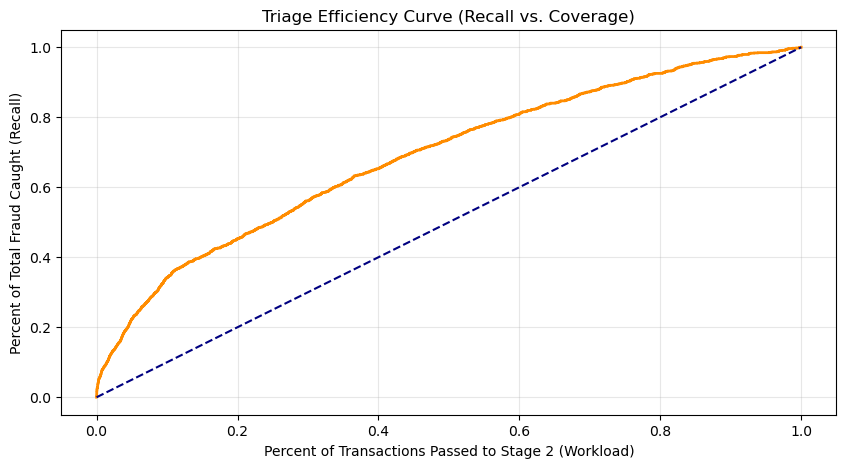

In [40]:
def evaluate_triage(y_true, y_probs, stages=[0.01, 0.05, 0.1, 0.2]):
    """
    Evaluates if the Triage stage is 'Wide' enough to catch fraud 
    but 'Narrow' enough to save Stage 2 from processing too much data.
    """
    # 1. Sort values by risk
    df_results = pd.DataFrame({'true': y_true, 'prob': y_probs})
    df_results = df_results.sort_values('prob', ascending=False).reset_index(drop=True)
    
    # 2. Calculate Cumulative Recall (The 'Catch' Rate)
    df_results['cum_fraud'] = df_results['true'].cumsum()
    total_fraud = df_results['true'].sum()
    df_results['cum_recall'] = df_results['cum_fraud'] / total_fraud
    
    # 3. Calculate Coverage (The 'Workload' for Stage 2)
    df_results['coverage'] = (df_results.index + 1) / len(df_results)
    
    print(f"--- TRIAGE PERFORMANCE REPORT ---")
    print(f"Total Transactions in Val: {len(y_true):,}")
    print(f"Total Fraud Cases: {int(total_fraud)}")
    print("-" * 35)
    
    for c in stages:
        # Find the index where coverage reaches the target percentage
        idx = (df_results['coverage'] >= c).idxmax()
        recall = df_results.loc[idx, 'cum_recall']
        
        # Calculate Lift (How much better than random)
        lift = recall / c
        
        print(f"At {c*100:>2.0f}% Coverage: Caught {recall:>6.2%} of fraud | Lift: {lift:.1f}x")

    # 4. Plot the Triage Efficiency Curve
    plt.figure(figsize=(10, 5))
    plt.plot(df_results['coverage'], df_results['cum_recall'], color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (Baseline)')
    plt.xlabel('Percent of Transactions Passed to Stage 2 (Workload)')
    plt.ylabel('Percent of Total Fraud Caught (Recall)')
    plt.title('Triage Efficiency Curve (Recall vs. Coverage)')
    plt.grid(alpha=0.3)
    plt.show()

# y_probs_val = triage_model.predict(X_val) 
evaluate_triage(y_val, y_probs_val)

In [41]:
from sklearn.utils import resample, shuffle

print("--- Balancing Stage 2 Training Data ---")

# 1. Separate Fraud and Normal from the Stage 2 Pool
X_fraud = X_train_s2[y_train_s2 == 1]
X_normal = X_train_s2[y_train_s2 == 0]

print(f"Pool Before Balancing -> Fraud: {len(X_fraud):,} | Normal: {len(X_normal):,}")

# 2. Surgical Undersampling (1:5 Ratio)
# We keep 100% of the Fraud, but pick 5 Normals for every 1 Fraud.
# This makes the "Needle in the Haystack" much easier to find.
X_normal_balanced = resample(X_normal, 
                             replace=False, 
                             n_samples=len(X_fraud) * 5, 
                             random_state=42)

# 3. Combine and Shuffle
# We OVERWRITE X_train_s2 so the next cell uses this balanced version automatically.
X_train_s2 = pd.concat([X_fraud, X_normal_balanced])
y_train_s2 = pd.concat([y_train_s2[X_fraud.index], y_train_s2[X_normal_balanced.index]])

# Shuffle to prevent order bias
X_train_s2, y_train_s2 = shuffle(X_train_s2, y_train_s2, random_state=42)

print(f"Data Balanced. New Training Size: {len(X_train_s2):,} rows (Ratio 1:5)")
print("(Proceed to Stacking Cell)")

--- Balancing Stage 2 Training Data ---
Pool Before Balancing -> Fraud: 13,085 | Normal: 2,959,716
Data Balanced. New Training Size: 78,510 rows (Ratio 1:5)
(Proceed to Stacking Cell)


In [42]:
print("Constructing Balanced Data for XGBoost (Fast Mode)...")

# 1. Separate Fraud and Normal from the Stage 2 Pool
# (These variables X_train_s2 come from your 'Filter Top 30%' cell)
X_fraud = X_train_s2[y_train_s2 == 1]
X_normal = X_train_s2[y_train_s2 == 0]

print(f"Original Pool -> Fraud: {len(X_fraud):,} | Normal: {len(X_normal):,}")

# 2. Surgical Undersampling (1:5 Ratio)
# We keep all fraud and pick 5x as many normals
X_normal_balanced = resample(X_normal, 
                             replace=False, 
                             n_samples=len(X_fraud) * 5, 
                             random_state=42)

# 3. Combine and Shuffle to create a temporary DataFrame
X_train_balanced_df = pd.concat([X_fraud, X_normal_balanced])
y_train_balanced_df = pd.concat([y_train_s2[X_fraud.index], y_train_s2[X_normal_balanced.index]])

X_train_balanced_df, y_train_balanced_df = shuffle(X_train_balanced_df, y_train_balanced_df, random_state=42)

# 4. Scale the Data -> Creates X_train_flat DIRECTLY
# This replaces the need for the "X_train_balanced" 3D array
scaler_xgb = StandardScaler()
X_train_flat = scaler_xgb.fit_transform(X_train_balanced_df)
y_train_flat = y_train_balanced_df.values

# 5. Prepare Validation Set (Real Imbalanced Data)
# We just scale it; we do NOT balance it.
X_val_flat = scaler_xgb.transform(X_val_s2)
y_val_flat = y_val_s2.values

print("-" * 30)
print(f" Data Ready.")
print(f"Training Shape (Balanced): {X_train_flat.shape}")
print(f"Validation Shape (Real):   {X_val_flat.shape}")

Constructing Balanced Data for XGBoost (Fast Mode)...
Original Pool -> Fraud: 13,085 | Normal: 65,425
------------------------------
 Data Ready.
Training Shape (Balanced): (78510, 19)
Validation Shape (Real):   (800000, 19)


In [45]:
print("--- STAGE 2: Training Specialist Stack ---")

# 1. Initialize the 3 Specialists
# We use diverse models so they make DIFFERENT mistakes
clf_xgb = XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.05,
    scale_pos_weight=1, 
    n_jobs=-1,
    random_state=42
)

clf_rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,        # Constrained depth prevents overfitting
    class_weight='balanced', 
    n_jobs=-1,
    random_state=42
)

clf_lgb = lgb.LGBMClassifier(
    n_estimators=200, 
    num_leaves=31, 
    scale_pos_weight=1, 
    n_jobs=-1, 
    verbose=-1,
    random_state=42
)

# 2. Train on the Stage 2 Data (X_train_s2)
print("Training Specialist 1: XGBoost...")
clf_xgb.fit(X_train_s2, y_train_s2)

print("Training Specialist 2: Random Forest...")
clf_rf.fit(X_train_s2, y_train_s2)

print("Training Specialist 3: LightGBM...")
clf_lgb.fit(X_train_s2, y_train_s2)

# 3. Create 'Stacking Features' (The Predictions)
# The Meta-Model learns from the probabilities of the specialists
def get_stack_features(X_input, model_xgb, model_rf, model_lgb):
    p1 = model_xgb.predict_proba(X_input)[:, 1]
    p2 = model_rf.predict_proba(X_input)[:, 1]
    p3 = model_lgb.predict_proba(X_input)[:, 1]
    return np.column_stack([p1, p2, p3])

print("Generating Meta-Features...")
X_stack_train = get_stack_features(X_train_s2, clf_xgb, clf_rf, clf_lgb)
# Note: For validation, we strictly use the Stage 2 subset we created earlier
X_stack_val = get_stack_features(X_val_s2, clf_xgb, clf_rf, clf_lgb)

# 4. Train the Meta-Model (The Judge)
# Logistic Regression decides who to trust
meta_model = LogisticRegression(class_weight='balanced', random_state=42)
meta_model.fit(X_stack_train, y_train_s2)

print("Stacking Complete. Calculating Final Metrics...")

# 5. Final Evaluation on VALIDATION Set
# We predict on the S2 validation subset
val_probs_s2 = meta_model.predict_proba(X_stack_val)[:, 1]

# Find Optimal Threshold for F1
precision, recall, thresholds = precision_recall_curve(y_val_s2, val_probs_s2)
f1_scores = 2 * recall * precision / (recall + precision + 1e-9)
best_f1_ix = np.argmax(f1_scores)
best_thresh = thresholds[best_f1_ix]

# Apply Threshold
y_pred_s2 = (val_probs_s2 >= best_thresh).astype(int)

print("\n" + "="*40)
print(f"FINAL RESULT (Stage 2 Only)")
print(f"Optimal Threshold: {best_thresh:.4f}")
print("="*40)
print(classification_report(y_val_s2, y_pred_s2, target_names=['Normal', 'Fraud']))

# Calculate Stage 2 Lift
prec_s2 = average_precision_score(y_val_s2, val_probs_s2)
print(f"Stage 2 AUPRC: {prec_s2:.4f}")

--- STAGE 2: Training Specialist Stack ---
Training Specialist 1: XGBoost...
Training Specialist 2: Random Forest...
Training Specialist 3: LightGBM...
Generating Meta-Features...
Stacking Complete. Calculating Final Metrics...

FINAL RESULT (Stage 2 Only)
Optimal Threshold: 0.9959
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    799004
       Fraud       0.02      0.03      0.02       996

    accuracy                           1.00    800000
   macro avg       0.51      0.51      0.51    800000
weighted avg       1.00      1.00      1.00    800000

Stage 2 AUPRC: 0.0046


--- Calculating Optimal Precision, Recall & F1 ---
Optimal Decision Threshold: 0.6677
Best F1 Score Possible: 0.0093

FINAL CLASSIFICATION REPORT (Stage 2)
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99    799004
       Fraud       0.00      0.08      0.01       996

    accuracy                           0.98    800000
   macro avg       0.50      0.53      0.50    800000
weighted avg       1.00      0.98      0.99    800000



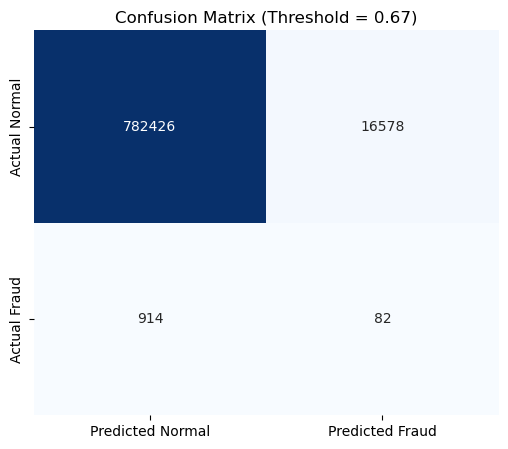

In [46]:
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Calculating Optimal Precision, Recall & F1 ---")

# 1. Get Probability Predictions
# (Make sure you use the flattened validation set)
y_probs = ensemble_model.predict_proba(X_val_flat)[:, 1]

# 2. Find the Threshold that gives the Best F1 Score
precision, recall, thresholds = precision_recall_curve(y_val_flat, y_probs)
fscore = (2 * precision * recall) / (precision + recall)
# Locate the index of the largest F1 score
ix = np.nanargmax(fscore)
best_thresh = thresholds[ix]

print(f"Optimal Decision Threshold: {best_thresh:.4f}")
print(f"Best F1 Score Possible: {fscore[ix]:.4f}")

# 3. Apply this Threshold to get Hard Predictions (0 or 1)
y_pred_optimal = (y_probs >= best_thresh).astype(int)

# 4. Print the Detailed Report
print("\n" + "="*40)
print(f"FINAL CLASSIFICATION REPORT (Stage 2)")
print("="*40)
print(classification_report(y_val_flat, y_pred_optimal, target_names=['Normal', 'Fraud']))

# 5. Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_val_flat, y_pred_optimal)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.2f})')
plt.show()

In [48]:
import joblib
import json

print("--- Saving Full Pipeline to Disk ---")

# 1. Save the Models
# Stage 0: The Gatekeeper
joblib.dump(iso_forest, 'stage0_isolation_forest.pkl')

# Stage 1: The Triage (Recall Enforcer)
joblib.dump(triage_voting_model, 'stage1_triage_lgbm.pkl')

# Stage 2: The Specialist Stack
joblib.dump(clf_xgb, 'stage2_specialist_xgb.pkl')
joblib.dump(clf_rf, 'stage2_specialist_rf.pkl')
joblib.dump(clf_lgb, 'stage2_specialist_lgb.pkl')
joblib.dump(meta_model, 'stage2_meta_logistic.pkl')

# 2. Save Critical Thresholds
pipeline_config = {
    "stage0_threshold": float(threshold_if),        # The score to drop boring data
    "stage1_threshold": float(triage_threshold),    # The probability to trigger Stage 2
    "stage2_threshold": float(best_thresh)          # The final decision (Fraud vs Normal)
}

with open('pipeline_config.json', 'w') as f:
    json.dump(pipeline_config, f)

print("All models and config saved successfully.")
print("files: stage0_..., stage1_..., stage2_..., pipeline_config.json")

--- Saving Full Pipeline to Disk ---
All models and config saved successfully.
files: stage0_..., stage1_..., stage2_..., pipeline_config.json


In [52]:

from sklearn.metrics import precision_score
print("=== FINAL STACKING MODEL LIFT ANALYSIS (Validation Set) ===")

# 1. Setup Variables from previous step
y_true_lift = y_val_s2
y_pred_lift = y_pred_s2

# 2. Base fraud rate (The odds of finding fraud by random guessing in Stage 2)
base_rate = y_true_lift.mean()

# 3. Precision at your chosen threshold
final_precision = precision_score(y_true_lift, y_pred_lift, zero_division=0)

# 4. Lift calculation
lift = final_precision / base_rate

print(f"Fraud Base Rate (Stage 2 Pool): {base_rate:.2%}")
print(f"Final Model Precision:          {final_precision:.2%}")
print("-" * 30)
print(f" LIFT Score:                  {lift:.2f}x")
print("(model is %.2f times better than random guessing)" % lift)

=== FINAL STACKING MODEL LIFT ANALYSIS (Validation Set) ===
Fraud Base Rate (Stage 2 Pool): 0.12%
Final Model Precision:          2.04%
------------------------------
 LIFT Score:                  16.37x
(model is 16.37 times better than random guessing)
